# IF + F regression + ELM


In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_validate, cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.ensemble import IsolationForest
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.pipeline import Pipeline


df = pd.read_excel("dataset.xlsx")
df.drop(columns=["Seli", "Tarih"], inplace=True, errors='ignore')

# mccinfo sütunundan dört haneli değeri çekmek için fonksiyon
def extract_mcc(value):
    if pd.isnull(value):
        return np.nan
    match = re.match(r"(\d{4})-", value)
    if match:
        return match.group(1)
    else:
        return np.nan

df['mccinfo'] = df['mccinfo'].apply(extract_mcc)
num_missing_mcc = df['mccinfo'].isnull().sum()
print(f"mccinfo değeri bulunamadığı için silinecek satır sayısı: {num_missing_mcc}")
df = df.dropna(subset=['mccinfo'])

# Sayısal sütunlardaki değerlerin düzenlenmesi
numeric_columns = [
    "bıst100_Kapanış", "bıst100_Açılış", "bıst100_Yüksek", "bıst100_Düşük",
    "Euro_Kapanış", "Euro_Açılış", "Euro_Yüksek", "Euro_Düşük",
    "USD_Kapanış", "USD_Açılış", "USD_Yüksek", "USD_Düşük",
]

def fix_numeric_value(s):
    s = s.replace(',', '.')
    if s.count('.') > 1:
        second_dot = s.find('.', s.find('.') + 1)
        s = s[:second_dot]
    return s

for col in numeric_columns:
    df[col] = df[col].astype(str).apply(fix_numeric_value)
    df[col] = df[col].astype(float)

# Kategorik sütunların kodlanması
categorical_columns = ["Şehir", "İlçe", "mccinfo"]
le = LabelEncoder()
for col in categorical_columns:
    df[col] = le.fit_transform(df[col])

# Hedef ve özniteliklerin ayrılması
target = "Tek Çekim Komisyon Oranı (Güncel)"
X = df.drop(columns=[target])
y = df[target]




mccinfo değeri bulunamadığı için silinecek satır sayısı: 15


In [ ]:
#IsolationForest
data_for_outlier = X.copy()
data_for_outlier[target] = y
iso_forest = IsolationForest(n_estimators=100, contamination="auto", random_state=42)
outlier_pred = iso_forest.fit_predict(data_for_outlier)
mask = outlier_pred == 1
print(f"Toplam örnek sayısı: {len(data_for_outlier)}")
print(f"Aykırı tespit edilen örnek sayısı: {np.sum(outlier_pred == -1)}")
X_clean = X[mask]
y_clean = y[mask]

Toplam örnek sayısı: 1692
Aykırı tespit edilen örnek sayısı: 286


In [ ]:
# ELM Regressor
class ELMRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, n_hidden=50, activation='sigmoid', random_state=None):
        self.n_hidden = n_hidden
        self.activation = activation
        self.random_state = random_state

    def _activation(self, x):
        if self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        elif self.activation == 'relu':
            return np.maximum(0, x)
        elif self.activation == 'tanh':
            return np.tanh(x)
        else:
            raise ValueError("Bilinmeyen aktivasyon fonksiyonu.")

    def fit(self, X, y):
        n_samples, n_features = X.shape
        rng = np.random.RandomState(self.random_state)
        # Rastgele input ağırlıkları ve bias değerleri oluşturuluyor
        self.input_weights_ = rng.randn(n_features, self.n_hidden)
        self.bias_ = rng.randn(self.n_hidden)
        # Gizli katmanın çıktısı hesaplanıyor
        H = self._activation(np.dot(X, self.input_weights_) + self.bias_)
        # Çıkış ağırlıkları, H'nin pseudoinverse'i kullanılarak hesaplanıyor
        self.beta_ = np.linalg.pinv(H).dot(y)
        return self

    def predict(self, X):
        H = self._activation(np.dot(X, self.input_weights_) + self.bias_)
        return np.dot(H, self.beta_)

pipeline = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_regression, k=10)),
    ('model', ELMRegressor(n_hidden=50, activation='tanh', random_state=123))
])

# 10 katlı KFold tanımlanıyor.
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

cv_results = cross_validate(pipeline, X_clean, y_clean, cv=kfold, return_estimator=True)

# Her fold için seçilen öznitelikleri ekrana yazdırıyoruz.
for i, est in enumerate(cv_results['estimator'], start=1):
    mask_selected = est.named_steps['feature_selection'].get_support()
    selected_feature_names = X_clean.columns[mask_selected]
    print(f"Fold {i} seçilen öznitelikler: {list(selected_feature_names)}")

# cross_val_predict ile tüm fold'lardan tahminler elde ediyoruz.
y_pred = cross_val_predict(pipeline, X_clean, y_clean, cv=kfold)



Fold 1 seçilen öznitelikler: ['basarili_satis_adet', 'basarili_satis_ciro', 'basarili_iade_ciro', 'Müşteri Skoru', 'Euro_Kapanış', 'Euro_Açılış', 'Euro_Yüksek', 'Euro_Düşük', 'Yıl', 'Ay']
Fold 2 seçilen öznitelikler: ['basarili_satis_ciro', 'Müşteri Skoru', 'bıst100_Açılış', 'Euro_Kapanış', 'Euro_Açılış', 'Euro_Yüksek', 'Euro_Düşük', 'USD_Kapanış', 'USD_Yüksek', 'Yıl']
Fold 3 seçilen öznitelikler: ['basarili_satis_ciro', 'basarili_iade_adet', 'basarili_iade_ciro', 'Müşteri Skoru', 'Euro_Kapanış', 'Euro_Açılış', 'Euro_Yüksek', 'Euro_Düşük', 'Yıl', 'Ay']
Fold 4 seçilen öznitelikler: ['basarili_satis_ciro', 'basarili_iade_ciro', 'Müşteri Skoru', 'Euro_Kapanış', 'Euro_Açılış', 'Euro_Yüksek', 'Euro_Düşük', 'USD_Kapanış', 'USD_Yüksek', 'Yıl']
Fold 5 seçilen öznitelikler: ['basarili_iade_ciro', 'Müşteri Skoru', 'bıst100_Kapanış', 'bıst100_Açılış', 'bıst100_Yüksek', 'Euro_Kapanış', 'Euro_Açılış', 'Euro_Yüksek', 'Euro_Düşük', 'Yıl']
Fold 6 seçilen öznitelikler: ['basarili_satis_adet', 'basarili

Mean Absolute Error (MAE): 0.514576614052366
Mean Absolute Percentage Error (MAPE): 0.12090334816890959
R2 Score: 0.04757659342521381


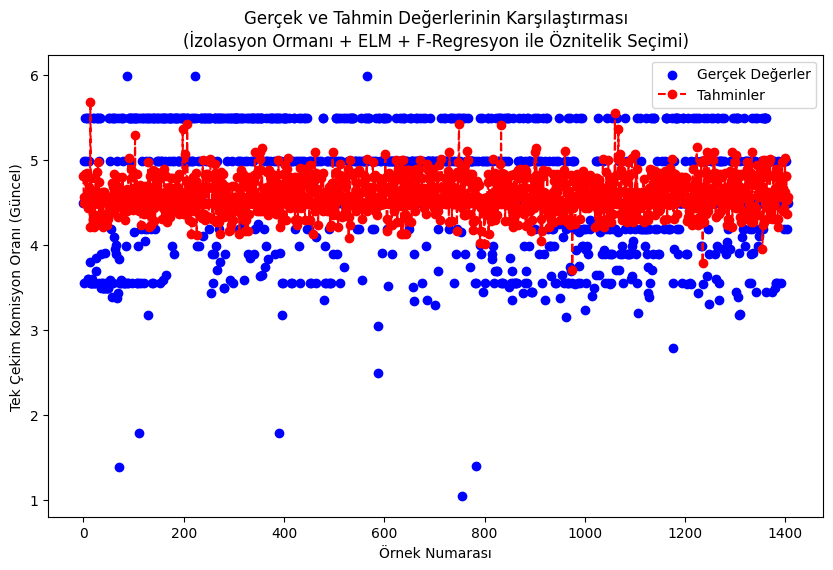

In [4]:
# Performans metriklerini hesaplıyoruz.
mae = mean_absolute_error(y_clean, y_pred)
mape = mean_absolute_percentage_error(y_clean, y_pred)
r2 = r2_score(y_clean, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")
print(f"R2 Score: {r2}")

# Sonuçların görselleştirilmesi
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_clean)), y_clean, color='blue', label='Gerçek Değerler')
plt.plot(range(len(y_pred)), y_pred, color="red", linestyle="--", marker="o", label="Tahminler")
plt.title("Gerçek ve Tahmin Değerlerinin Karşılaştırması\n(İzolasyon Ormanı + ELM + F-Regresyon ile Öznitelik Seçimi)")
plt.xlabel("Örnek Numarası")
plt.ylabel("Tek Çekim Komisyon Oranı (Güncel)")
plt.legend()
plt.show()


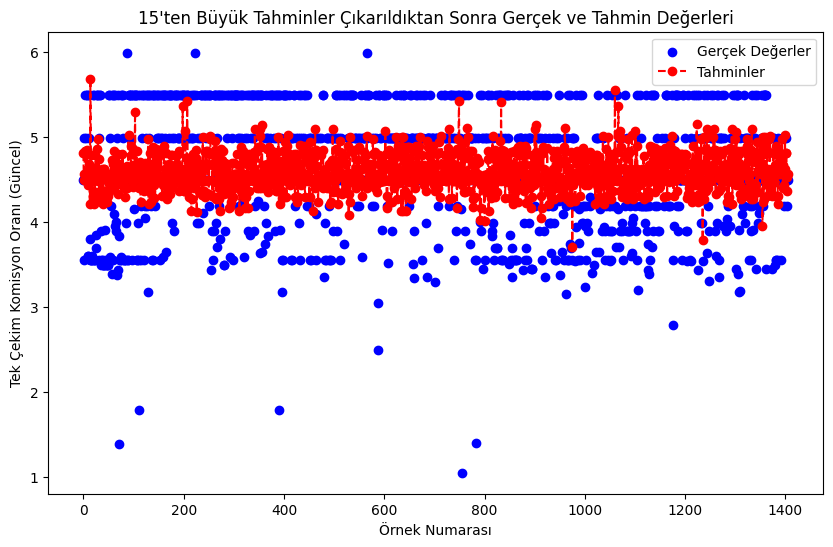

In [5]:
# Tahmin değeri 15'ten büyük olan örneklerin indekslerini buluyoruz.
indices_over15 = np.where(y_pred > 15)[0]

# Her bir index için öznitelikler, tahmin ve gerçek değerleri ekrana yazdırıyoruz.
for idx in indices_over15:
    print(f"Index: {idx}")
    # X_clean, orijinal özelliklerin bulunduğu DataFrame olduğu varsayılıyor.
    print("Öznitelikler:", X_clean.iloc[idx].to_dict())
    print("Tahmin Değeri:", y_pred[idx])
    print("Gerçek Değer:", y_clean.iloc[idx])
    print("-" * 40)

# 15'ten büyük tahminleri veri setinden çıkarıyoruz.
all_indices = np.arange(len(y_clean))
remaining_indices = np.setdiff1d(all_indices, indices_over15)

# Kalan örneklerin gerçek ve tahmin değerlerini alıyoruz.
y_clean_remaining = y_clean.iloc[remaining_indices]
y_pred_remaining = y_pred[remaining_indices]

# Yeni grafik: 15'ten büyük tahminler çıkarıldıktan sonra.
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_clean_remaining)), y_clean_remaining, color='blue', label='Gerçek Değerler')
plt.plot(range(len(y_pred_remaining)), y_pred_remaining, color="red", linestyle="--", marker="o", label="Tahminler")
plt.title("15'ten Büyük Tahminler Çıkarıldıktan Sonra Gerçek ve Tahmin Değerleri")
plt.xlabel("Örnek Numarası")
plt.ylabel("Tek Çekim Komisyon Oranı (Güncel)")
plt.legend()
plt.show()
